Introduction
=========

Hi all, this is my first Kaggle kernel and really one of the first data science problems I've tackled by myself. We'll go through some basic data wrangling then explore a bunch of simple learning methods and see how they stack up against each other. This kernel aims to be primarily educational for any other beginner Kaggler's looking to get started!

Prepping the Data
================

Loading
----------

In [1]:
fr_train = read.csv('../input/train.csv', na.strings='')
dim(fr_train)
head(fr_train)

[1] 891  12

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


The head function can be used on a dataframe to view the first n rows, in R the default is n = 6. It's a useful function to get a quick peak at the data you're working with; in particular whether a feature is categorical or numerical, as well as typical values. Right off the bat spot an idiosyncracy in our dataset, namely that we seem to be missing a lot of values in our `Cabin` feature. Dealing with missing data is an important step in any machine learning pipeline, and we'll spend a bit of time on it a little later on. But first, let's continue exploring some basic properties of our dataset.

In [2]:
summary(fr_train)

  PassengerId       Survived          Pclass     
 Min.   :  1.0   Min.   :0.0000   Min.   :1.000  
 1st Qu.:223.5   1st Qu.:0.0000   1st Qu.:2.000  
 Median :446.0   Median :0.0000   Median :3.000  
 Mean   :446.0   Mean   :0.3838   Mean   :2.309  
 3rd Qu.:668.5   3rd Qu.:1.0000   3rd Qu.:3.000  
 Max.   :891.0   Max.   :1.0000   Max.   :3.000  
                                                 
                                    Name         Sex           Age       
 Abbing, Mr. Anthony                  :  1   female:314   Min.   : 0.42  
 Abbott, Mr. Rossmore Edward          :  1   male  :577   1st Qu.:20.12  
 Abbott, Mrs. Stanton (Rosa Hunt)     :  1                Median :28.00  
 Abelson, Mr. Samuel                  :  1                Mean   :29.70  
 Abelson, Mrs. Samuel (Hannah Wizosky):  1                3rd Qu.:38.00  
 Adahl, Mr. Mauritz Nils Martin       :  1                Max.   :80.00  
 (Other)                              :885                NA's   :177    
     Sib

The `summary()` function can be used to summarise basical statistical properties of each feature in a dataframe. Let's run through what we see here.

First of all the mean of `Survived` is 0.38, meaning only 38% of people survived in this dataset. Naturally this means we have more data pertaining to passengers who died, so it wouldn't be too suprising if our model ends up being better at able to predict who dies than who survives but this is something we'll have to evaluate later.

There's also more males than females in this dataset by a fairly significant margin, 577 versus 314. Most interestingly take a look at `Cabin`, there's a whopping 687 NA's. That's a lot of missing data, note that `Age` and `Embarked` are missing values as well but not nearly as much.

I like to quickly make helper functions which give me neat, explicit output about what I'm concerned with. Since we're about to deal with a lot of missing data I'm going to make a short, simple function which summarises the missing data in any generic dataframe.

In [3]:
naSummary = function(df) {
    naCount = sapply(df, function(col) {
        sum(is.na(col))
    })
    
    return (data.frame(naCount, naPc=naCount/nrow(df)))
}

naSummary(fr_train)

,naCount,naPc
PassengerId,0,0.000000000
Survived,0,0.000000000
Pclass,0,0.000000000
Name,0,0.000000000
Sex,0,0.000000000
Age,177,0.198653199
SibSp,0,0.000000000
Parch,0,0.000000000
Ticket,0,0.000000000
Fare,0,0.000000000


Let's take a look at our data types as the last preliminary check to make sure everything looks good.

In [4]:
str(fr_train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 147 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


We should remove passenger ID because it's a useless feature, let's also explicitly convert `Survived` and `Pclass` to factors as that's what they are.

In [5]:
fr_train$Survived = as.factor(fr_train$Survived)
fr_train$Pclass = as.factor(fr_train$Pclass)

fr_train = subset(fr_train, select=-c(PassengerId))

str(fr_train)

'data.frame':	891 obs. of  11 variables:
 $ Survived: Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass  : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name    : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket  : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin   : Factor w/ 147 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...
 $ Embarked: Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


Missing Data Imputation
----------------------

There's essentially two strategies you can employ when you have to deal with missing data. You can throw out the entries with missing variables, or you can replace the missing variables with your best guess. This latter process is called imputation. The downside of throwing data out is simply that you'll have less data to train your model on, but it's really simple to do. Strategies for imputation can range from very easy to quite complex, it's an extensive topic in and of itself and you should spend some time reading up on it.

### Embarked

Let's go from easy to hard, and start off with the `Embarked` feature which is only missing two values. This is a totally trivial amount of missing data so we'll just use a really simple 'most frequent' imputation which is exactly what it sounds like, replace the missing value with the most frequent level for that feature.

In [6]:
mcl = fr_train$Embarked[which.max(fr_train$Embarked)]
fr_train$Embarked[which(is.na(fr_train$Embarked))] = mcl

naSummary(fr_train)

,naCount,naPc
Survived,0,0.0000000
Pclass,0,0.0000000
Name,0,0.0000000
Sex,0,0.0000000
Age,177,0.1986532
SibSp,0,0.0000000
Parch,0,0.0000000
Ticket,0,0.0000000
Fare,0,0.0000000
Cabin,687,0.7710438


### Age

`Age` is a bit harder, we're missing a non-trivial amount of values. We're going to attempt a random regression imputation. This involves developing a regression model between `Age` and a set of predictors from the dataset, then adding a residual term to the prediction in order to reintroduce randomosity to the imputed values. Effectively this is another machine learning problem within our bigger Titanic machine learning problem!

We're going to need features so we can do a bit of feature engineering here. In particular I want to extract the Title of each passenger from the `Name` feature, a look at the data shows that the title "Master" seems to be reserved for males under the age of 13. I'd also expect there to be a correlation between the title "Miss" and younger females.

In [7]:
getTitle = function(name) {
    postcom = trimws(strsplit(as.character(name), ',')[[1]][2])
    title = strsplit(postcom, ' ')[[1]][1]
    return (substr(title, 1, nchar(title)-1))
}

fr_train$Title = as.factor(sapply(fr_train$Name, getTitle))
fr_train = fr_train[c("Survived", 
                      "Pclass",  
                      "Name",
                      "Title",
                      "Sex", 
                      "Age", 
                      "SibSp", 
                      "Parch", 
                      "Ticket", 
                      "Fare", 
                      "Cabin", 
                      "Embarked")]

head(fr_train)

Survived,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",Mr,male,22,1,0,A/5 21171,7.2500,NA,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",Mrs,female,38,1,0,PC 17599,71.2833,C85,C
1,3,"Heikkinen, Miss. Laina",Miss,female,26,0,0,STON/O2. 3101282,7.9250,NA,S
1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,female,35,1,0,113803,53.1000,C123,S
0,3,"Allen, Mr. William Henry",Mr,male,35,0,0,373450,8.0500,NA,S
0,3,"Moran, Mr. James",Mr,male,NA,0,0,330877,8.4583,NA,Q


So far looks good! Let's use `summary()` to get a better look.

In [8]:
summary(fr_train$Title)

Capt      Col      Don       Dr Jonkheer     Lady    Major   Master 
       1        2        1        7        1        1        2       40 
    Miss     Mlle      Mme       Mr      Mrs       Ms      Rev      Sir 
     182        2        1      517      125        1        6        1 
      th 
       1

There's a lot of special titles being used for a small number of passengers. Let's coerce them to common values so we only deal with the following subset of titles:

* Mr
* Mrs
* Miss
* Master

We'll use the following mappings.

* Dr, Rev, Major, Col, Jonkheer, Don, Sir, Capt -> Mr
* Mlle, Ms -> Miss
* Lady, Mme, th -> Mrs

I think there would be some amount of predictive power to these title if we had more data, but as it stands these honorifics just don't have enough entries to act as standalone features so we're merging them with the most appropriate alternate level.

Since we're removing a lot of levels we have to use the `droplevels()` command to remove them from the feature within R.

In [9]:
mr_alias = c('Dr', 'Rev', 'Major', 'Col', 'Jonkheer', 'Don', 'Sir', 'Capt')
mrs_alias = c('Lady', 'Mme', 'th')
miss_alias = c('Mlle', 'Ms')

fr_train$Title[which(fr_train$Title %in% mr_alias)] = 'Mr'
fr_train$Title[which(fr_train$Title %in% mrs_alias)] = 'Mrs'
fr_train$Title[which(fr_train$Title %in% miss_alias)] = 'Miss'

fr_train$Title = droplevels(fr_train$Title)
summary(fr_train$Title)

Master   Miss     Mr    Mrs 
    40    185    538    128

Great! Now that's all done and we have what's hopefully a useful, additional feature for our Age random regression imputation. We can finally get started with our actual random regression to impute our missing `Age` values.

First I'm going to define a new dataframe which contains only the features we need to deal with to train our regression model, this means excluding `Name`, `Ticket` and `Cabin`.

In [10]:
rr_train = subset(fr_train, select=-c(Name, Ticket, Cabin))
rr_train = na.omit(rr_train)

head(rr_train)

,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,Mr,male,22,1,0,7.2500,S
2,1,1,Mrs,female,38,1,0,71.2833,C
3,1,3,Miss,female,26,0,0,7.9250,S
4,1,1,Mrs,female,35,1,0,53.1000,S
5,0,3,Mr,male,35,0,0,8.0500,S
7,0,1,Mr,male,54,0,0,51.8625,S


In [11]:
lm.fit = lm(Age ~ ., data=rr_train)
summary(lm.fit)


Call:
lm(formula = Age ~ ., data = rr_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.265  -8.247  -1.115   6.391  43.746 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  30.85611   11.52210   2.678 0.007580 ** 
Survived1    -3.88381    1.13142  -3.433 0.000633 ***
Pclass2     -10.69903    1.39197  -7.686 5.13e-14 ***
Pclass3     -15.30255    1.34065 -11.414  < 2e-16 ***
TitleMiss     3.61614   11.36963   0.318 0.750540    
TitleMr      20.25307    2.32670   8.705  < 2e-16 ***
TitleMrs     17.46880   11.36564   1.537 0.124749    
Sexmale      -7.58790   11.15406  -0.680 0.496551    
SibSp        -2.26870    0.53511  -4.240 2.54e-05 ***
Parch        -0.45410    0.56819  -0.799 0.424444    
Fare         -0.01437    0.01045  -1.374 0.169830    
EmbarkedQ     7.48265    2.39817   3.120 0.001882 ** 
EmbarkedS     2.14713    1.16359   1.845 0.065420 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard err

Let's take a quick look at these p-values. `Survival` is a statistically significant feature in predicting `Age` as we should expect, "women and children first". `Pclass` is significant too, let's make a quick boxplot to investigate that a bit further.

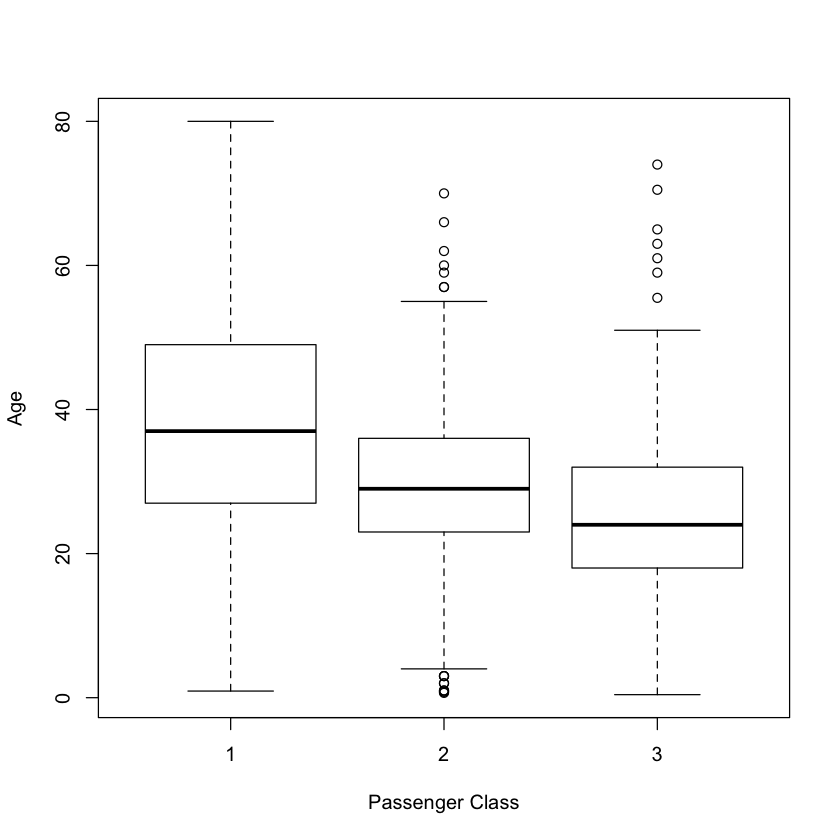

In [12]:
plot(rr_train$Pclass, rr_train$Age, xlab="Passenger Class", ylab="Age")

Looks like first class passengers skew older which isn't suprising. Looks like `Title` is a significant feature too so our little bit of feature engineering has paid off! `Sex` has no significance which isn't particularly surprising either. The number of siblings/spouses in `SibSp` is significant as well, my guess is that younger people tend to have a higher count as they likely have siblings on board and of course you're likely to have more siblings than spouses. Another boxplot should help us determine this.

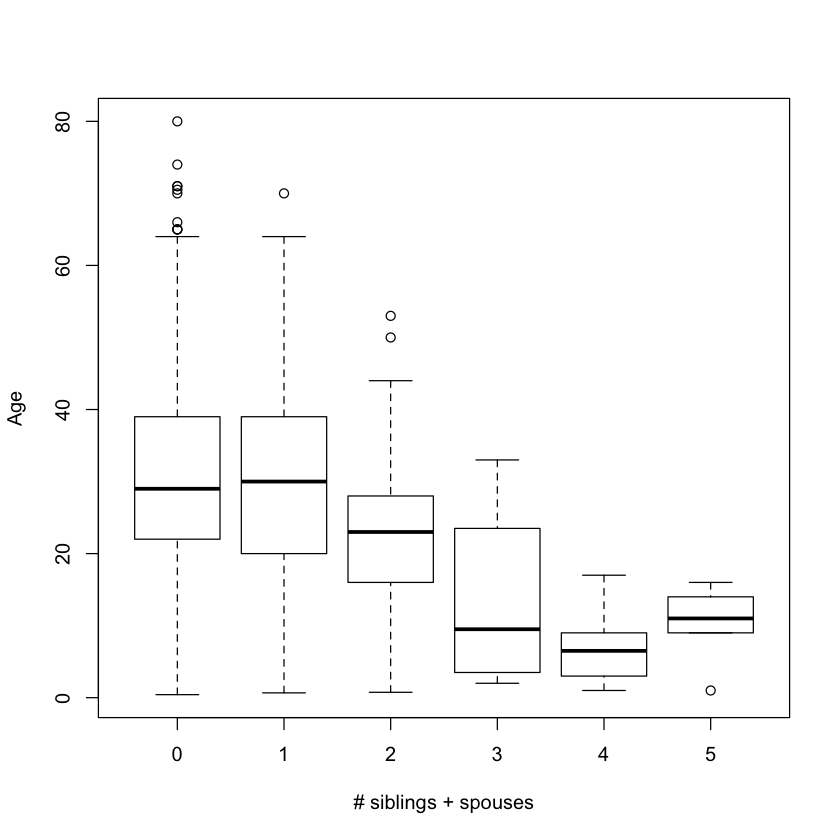

In [13]:
plot(as.factor(rr_train$SibSp), rr_train$Age, xlab="# siblings + spouses", ylab="Age")

Bingo, looks like that's exactly the trend. The last significant feature is `Embarked`, in particular if you embarked from location Q. To be honest I have no idea why, if you do know leave a comment because I'm curious!

Let's create a simpler regression model which excludes the insignificant features: `Sex`, `Parch` and `Fare`.

In [14]:
lm.fit = lm(Age ~ Survived + Pclass + Title + SibSp + Embarked, data=rr_train)

summary(lm.fit)


Call:
lm(formula = Age ~ Survived + Pclass + Title + SibSp + Embarked, 
    data = rr_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.660  -8.260  -1.260   6.602  43.740 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  21.5312     2.7309   7.884 1.21e-14 ***
Survived1    -3.8171     1.1253  -3.392 0.000732 ***
Pclass2      -9.8474     1.2410  -7.935 8.29e-15 ***
Pclass3     -14.3566     1.1253 -12.758  < 2e-16 ***
TitleMiss    11.2392     2.2224   5.057 5.43e-07 ***
TitleMr      20.6877     2.2774   9.084  < 2e-16 ***
TitleMrs     25.0590     2.2747  11.016  < 2e-16 ***
SibSp        -2.5076     0.5146  -4.873 1.36e-06 ***
EmbarkedQ     7.8683     2.3906   3.291 0.001047 ** 
EmbarkedS     2.3971     1.1522   2.080 0.037842 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.08 on 704 degrees of freedom
Multiple R-squared:  0.4257,	Adjusted R-squared:  0.4183 
F-statistic: 57.97 on 9 and 704

Now this definitely isn't the best `Age` predictor but remember this is just for imputation, effectively we're trying to maintain the relationships between `Age` and other variables which exist so as not to diffuse the strength of any patterns in the data when we build our actual Survival predictor. Other strategies like estimating a distribution then simply sampling from that randomly maintains the state of information we have about `Age`, but potentially weakens the patterns between `Age` and other features.

Finally, let's do our imputation. But first I'm going to see if there's any people with the title "Master" that have missing ages, remember that title appears to be reserved for males under the age of 13. It'll be an interesting test to see if our imputed ages maintain that criteria.

In [15]:
missing_age_masters = which(fr_train$Title == 'Master' & is.na(fr_train$Age))
fr_train[missing_age_masters, ]

,Survived,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
66,1,3,"Moubarek, Master. Gerios",Master,male,NA,1,1,2661,15.2458,NA,C
160,0,3,"Sage, Master. Thomas Henry",Master,male,NA,8,2,CA. 2343,69.5500,NA,S
177,0,3,"Lefebre, Master. Henry Forbes",Master,male,NA,3,1,4133,25.4667,NA,S
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",Master,male,NA,1,1,2661,15.2458,NA,C


We'll make note of these four and proceed to do our random regression imputation.

In [16]:
det_imputed = predict(lm.fit, fr_train[which(is.na(fr_train$Age)), ])
random_imputed = rnorm(length(det_imputed), det_imputed, abs(residuals(lm.fit)))

# We need to round the values to integers and floor them at a value of 1
random_imputed[which(random_imputed < 1)] = 1
random_imputed = round(random_imputed)

Let's take a look at the original values vs the imputed values.

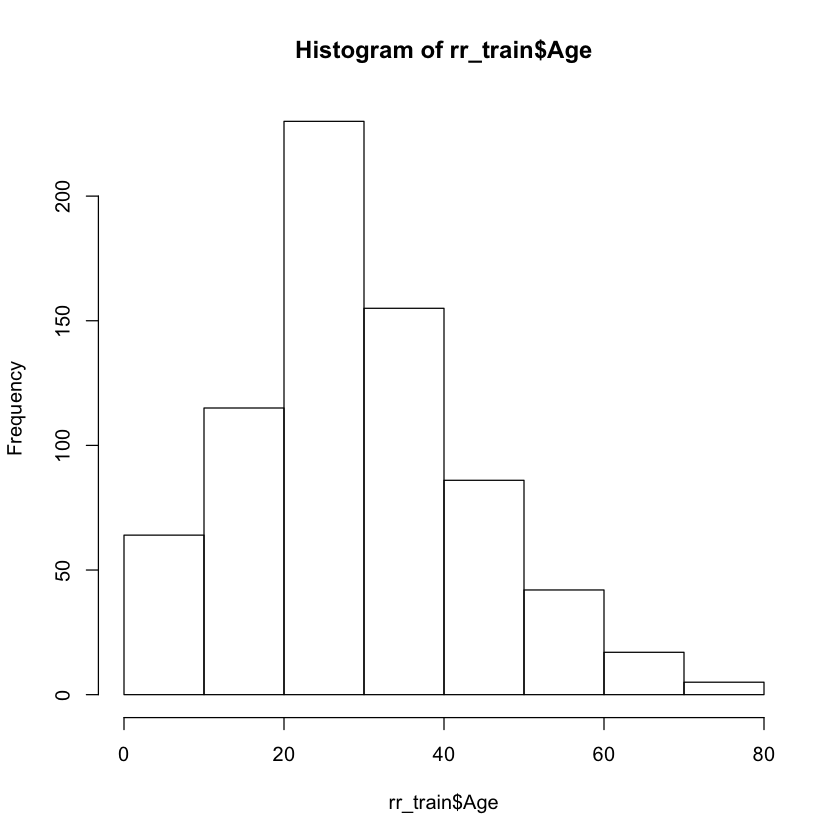

In [17]:
hist(rr_train$Age)

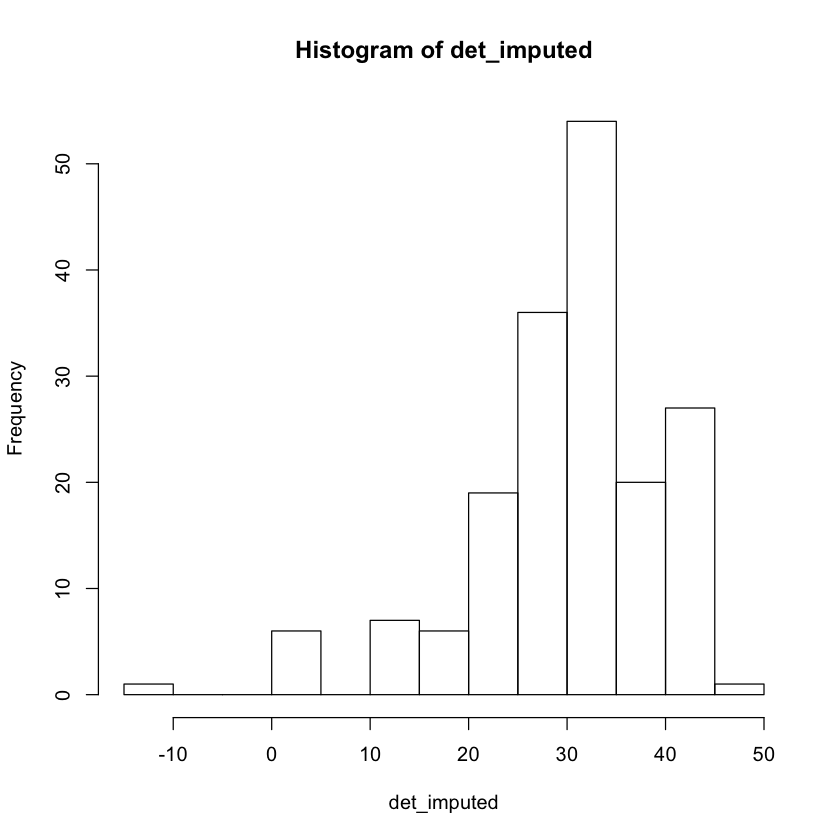

In [18]:
hist(det_imputed)

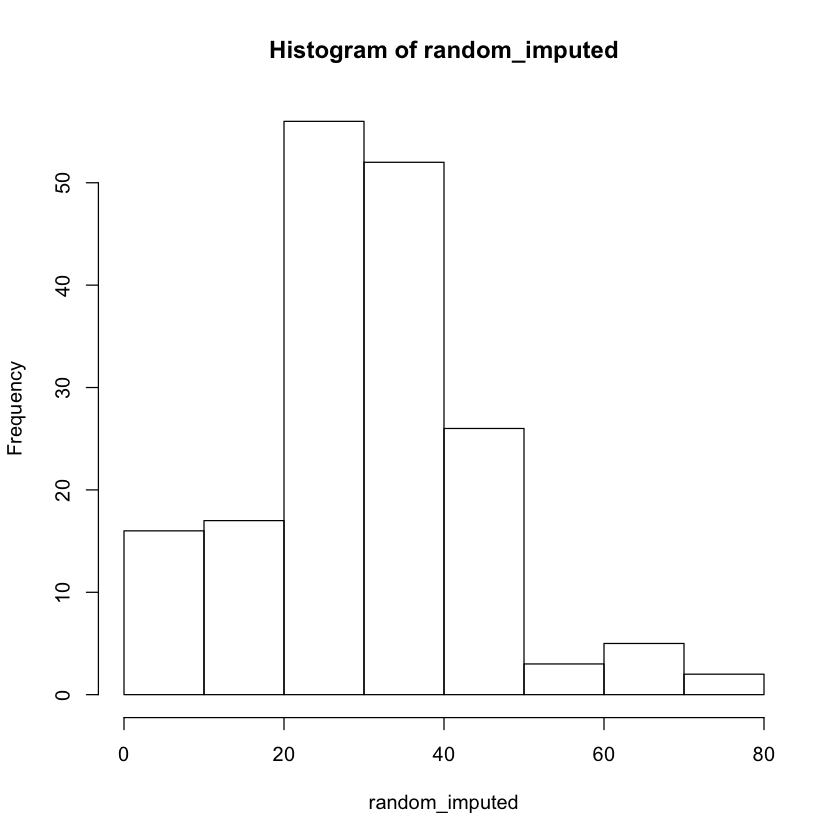

In [19]:
hist(random_imputed)

Under the assumption that the missing values are missing completely at random and with sufficient missing values, we would expect our histograms of the imputed values to be very similar to the original values. This seems to be what we're seeing here. It's also good to compare the deterministic imputations vs the random imputations, the deterministic imputations lie on the regression line by definition. This basically means that it assumes there's a deterministic relationship between the predictors and the target which is not desirable. The random imputation takes the deterministic imputations and adds an error term proportional to the residual for that point. Effectively we try and reintroduce appropriate variance in the imputed values.

Violin plots really help us see this effect.

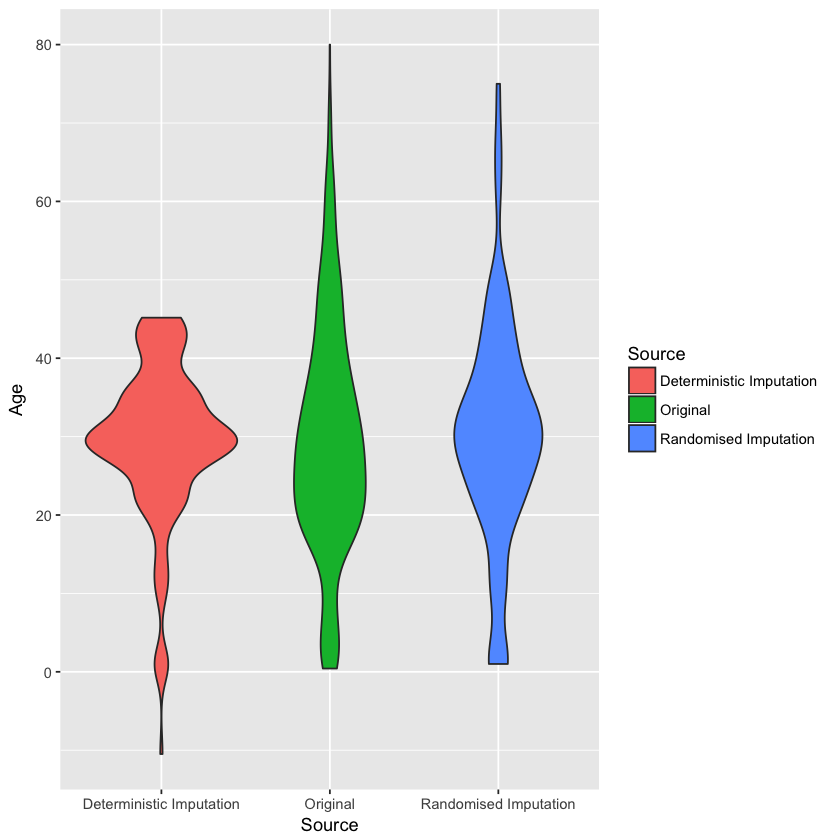

In [20]:
library(ggplot2)

kde_mat = rbind(cbind(rr_train$Age, rep("Original", length(rr_train$Age))),
        cbind(det_imputed, rep("Deterministic Imputation", length(det_imputed))),
        cbind(random_imputed, rep("Randomised Imputation", length(random_imputed))))

kde_df = data.frame(Age=as.numeric(kde_mat[,1]), Source=as.factor(kde_mat[,2]))

ggplot(kde_df, aes(x=Source, y=Age, fill=Source)) + geom_violin()

# lines(density(det_imputed), col='green')
# lines(density(random_imputed), col='red')
# points(det_imputed, col='red')
# points(random_imputed, col='green')

Let's merge the imputed values back into our dataframe now.

In [21]:
fr_train$Age[which(is.na(fr_train$Age))] = random_imputed
naSummary(fr_train)

,naCount,naPc
Survived,0,0.0000000
Pclass,0,0.0000000
Name,0,0.0000000
Title,0,0.0000000
Sex,0,0.0000000
Age,0,0.0000000
SibSp,0,0.0000000
Parch,0,0.0000000
Ticket,0,0.0000000
Fare,0,0.0000000


Let's go back to the 4 passengers with the "Master" title and missing ages now and see what the randomised imputations they received were.

In [22]:
fr_train[missing_age_masters,]

,Survived,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
66,1,3,"Moubarek, Master. Gerios",Master,male,2,1,1,2661,15.2458,NA,C
160,0,3,"Sage, Master. Thomas Henry",Master,male,1,8,2,CA. 2343,69.5500,NA,S
177,0,3,"Lefebre, Master. Henry Forbes",Master,male,1,3,1,4133,25.4667,NA,S
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",Master,male,1,1,1,2661,15.2458,NA,C


Remember we expected them to have an `Age` of less than 13 and we do see that, though it does seem heavily skewed towards the bottom end of the scale. Regardless this is a hopeful indication that our random regression imputation has succeeded in preserving relationships between Age and the other features in the dataset.

### Cabin

Let's be practical, it's not really possible to impute values for `Cabin` given the nature of the data. Instead let's focus on transforming it into a useful feature in the feature engineering phase.

Feature Engineering
===========

Cabin
-----

Since we're missing most of our Cabin values the simplest strategy to see if this could be a useful feature would be to encode it as a simple binary variable, whether a Cabin is listed or not.

In [25]:
fr_train$hasCabin = as.factor(ifelse(is.na(fr_train$Cabin), 0, 1))

freq = table(fr_train$hasCabin, fr_train$Survived)
as.data.frame.matrix(freq, )

,0,1
0,481,206
1,68,136
